In [41]:
from source.ion_channel import IonChannel
from source.patch_clamp import PatchClamp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import threading

# This controls the number of points before and after the random midpoint to be taken for LSTM
N_POINTS = 50


In [ ]:
# X_Mixture_density
X_MD = []
y_MD = []
X_LSTM = []
y_LSTM = []
X = []
y = []
def data_generation():
    for i in range(1500):
        random_ion_number = np.random.randint(1, 4)
        patch_clamp = PatchClamp([IonChannel(1000) for _ in range(random_ion_number)])
        normalized_X = (patch_clamp.X - np.min(patch_clamp.X)) / (np.max(patch_clamp.X) - np.min(patch_clamp.X))
        bins = np.linspace(0, 1, 101)
        hist_X, _ = np.histogram(normalized_X, bins=bins)
        X_MD.append(hist_X)
        # convert to one-hot
        np_y = np.zeros(3, dtype=int)
        np_y[random_ion_number - 1] = 1
        y_MD.append(np_y)
    
        # LSTM data, 50 points before and after
        random_mid_point = np.random.randint(N_POINTS, len(normalized_X) - N_POINTS)
        start_point = random_mid_point - N_POINTS
        end_point = random_mid_point + N_POINTS
    
        X_LSTM.append(normalized_X[start_point:end_point + 1])
        np_y = np.zeros(4, dtype=int)
        np_y[int(patch_clamp.y[random_mid_point])] = 1
        y_LSTM.append(np_y)
    
        X.append(normalized_X)
        y.append(patch_clamp.y)
        

data_generation()

In [26]:
X_MD = np.array(X_MD)
y_MD = np.array(y_MD)
X_LSTM = np.array(X_LSTM).reshape(-1, 2 * N_POINTS + 1, 1)
y_LSTM = np.array(y_LSTM).reshape(-1, 4)
X = np.array(X)
y = np.array(y)

print('X_MD:\t', X_MD.shape)
print('y_MD:\t', y_MD.shape)
print('X_LSTM:\t', X_LSTM.shape)
print('y_LSTM:\t', y_LSTM.shape)
print('X:\t\t', X.shape)
print('y:\t\t', y.shape)

X_MD:	 (1500, 100)
y_MD:	 (1500, 3)
X_LSTM:	 (1500, 101, 1)
y_LSTM:	 (1500, 4)
X:		 (1500, 1000)
y:		 (1500, 1000)


In [27]:
# Split the data into training and testing with 80% training and 20% testing
split = int(0.8 * len(X_MD))
X_MD_train, X_MD_test = X_MD[:split], X_MD[split:]
y_MD_train, y_MD_test = y_MD[:split], y_MD[split:]
X_LSTM_train, X_LSTM_test = X_LSTM[:split], X_LSTM[split:]
y_LSTM_train, y_LSTM_test = y_LSTM[:split], y_LSTM[split:]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model

In [33]:
class CustomModel(keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.lstm_layer = tf.keras.layers.LSTM(units=100)  # Define LSTM layer with 128 units
        self.lstm_dense_layer = tf.keras.layers.Dense(units=4, activation='softmax')  # Output dense layer with 4 nodes
        
        self.MD_layer = tf.keras.layers.Dense(units=101, activation='relu')
        self.MD_middle_layer = tf.keras.layers.Dense(units=50, activation='relu')
        self.MD_output_layer = tf.keras.layers.Dense(units=3, activation='softmax')
        
        self.concat = tf.keras.layers.Concatenate()
        
        self.output_layer = tf.keras.layers.Dense(units=4, activation='softmax')
        

    def call(self, inputs, **kwargs):
        # LSTM
        x = self.lstm_layer(inputs[0])
        x = self.lstm_dense_layer(x)
        
        # Mixture Density
        y = self.MD_layer(inputs[1])
        y = self.MD_middle_layer(y)
        y = self.MD_output_layer(y)
        
        # Concatenate the two outputs
        z = self.concat([x, y])
        
        # Output layer
        z = self.output_layer(z)
        
        return z
        

In [34]:
model = CustomModel()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
training_info = model.fit([X_LSTM_train, X_MD_train], y_LSTM_train, epochs=50, batch_size=32, validation_data=([X_LSTM_test, X_MD_test], y_LSTM_test))

Epoch 1/50
38/38 [==============================] - 2s 42ms/step - loss: 0.3685 - accuracy: 0.8725 - val_loss: 0.5161 - val_accuracy: 0.8300
Epoch 2/50
38/38 [==============================] - 2s 43ms/step - loss: 0.3583 - accuracy: 0.8883 - val_loss: 0.5653 - val_accuracy: 0.7967
Epoch 3/50
38/38 [==============================] - 2s 43ms/step - loss: 0.3536 - accuracy: 0.8908 - val_loss: 0.5071 - val_accuracy: 0.8200
Epoch 4/50
38/38 [==============================] - 2s 42ms/step - loss: 0.3093 - accuracy: 0.9158 - val_loss: 0.4841 - val_accuracy: 0.8300
Epoch 5/50
38/38 [==============================] - 1s 38ms/step - loss: 0.3148 - accuracy: 0.9067 - val_loss: 0.4984 - val_accuracy: 0.8233
Epoch 6/50
38/38 [==============================] - 1s 38ms/step - loss: 0.3332 - accuracy: 0.8975 - val_loss: 0.4959 - val_accuracy: 0.8233
Epoch 7/50
38/38 [==============================] - 1s 38ms/step - loss: 0.3729 - accuracy: 0.8817 - val_loss: 0.5725 - val_accuracy: 0.7833
Epoch 8/50
38

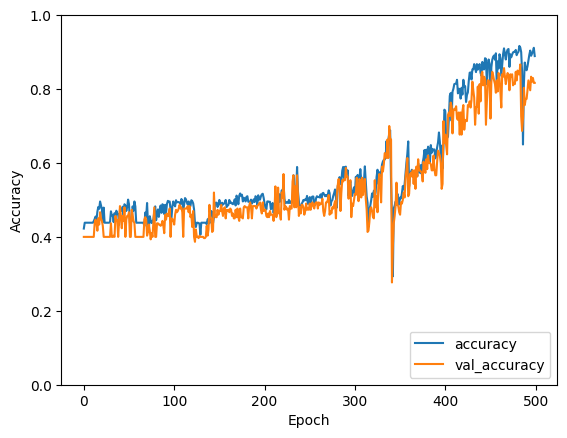

In [36]:
plt.plot(training_info.history['accuracy'], label='accuracy')
plt.plot(training_info.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [37]:
# save the model
model.save('models/state_estimator_and_LSTM_normalized_50_50_artificial_data.keras')

In [40]:
# Test the model
y_pred = model.predict([X_LSTM_test, X_MD_test])
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_LSTM_test, axis=1)
print('Accuracy:', np.mean(y_pred == y_true))

10/10 [==============================] - 0s 12ms/step
Accuracy: 0.8166666666666667
